In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(47)

stock_data = pd.read_csv('/content/drive/MyDrive/amazon_stock_data.csv')
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-06-02,0.075521,0.076563,0.075000,0.075521,0.075521,11832000
1,1997-06-03,0.076563,0.076563,0.073958,0.073958,0.073958,23664000
2,1997-06-04,0.073958,0.074479,0.069792,0.070833,0.070833,61608000
3,1997-06-05,0.070833,0.077083,0.068750,0.077083,0.077083,113448000
4,1997-06-06,0.075781,0.085417,0.075521,0.082813,0.082813,156144000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


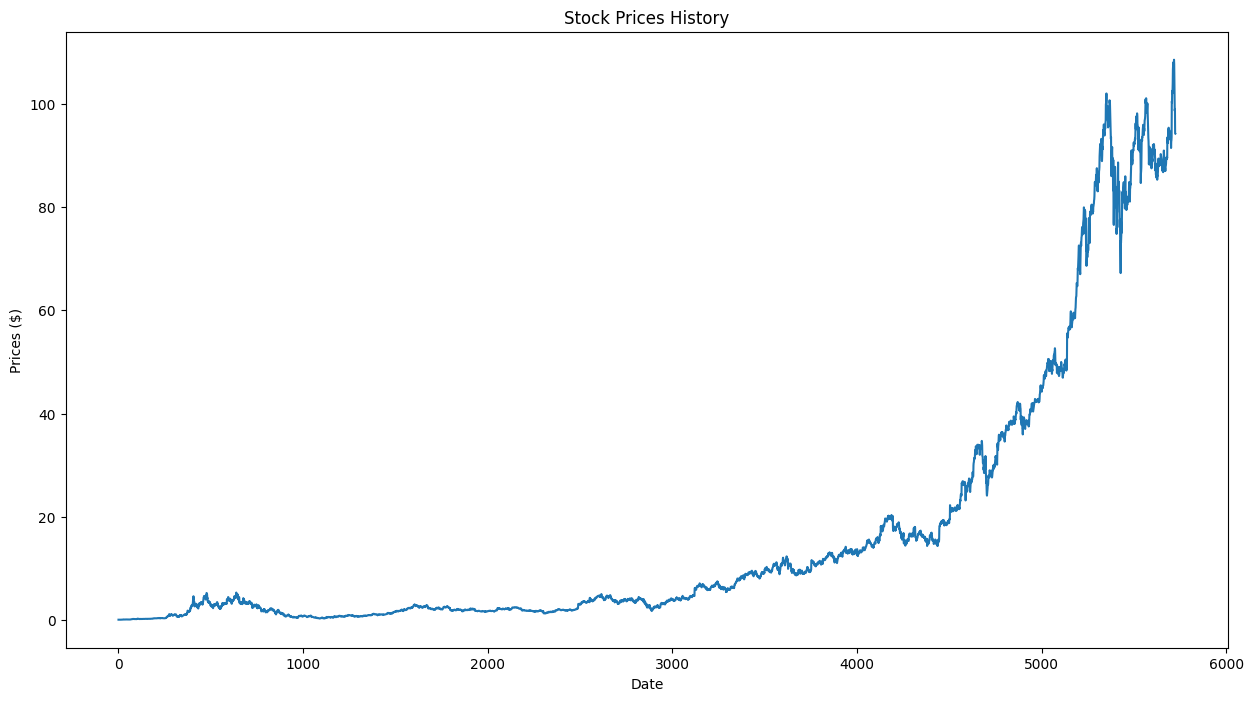

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.savefig('plt_gt.jpg')

In [ ]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
4520/4520 [==============================] - 51s 8ms/step - loss: 6.5578e-05
Epoch 2/3
4520/4520 [==============================] - 37s 8ms/step - loss: 2.3673e-05
Epoch 3/3
4520/4520 [==============================] - 38s 8ms/step - loss: 2.0756e-05


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

36/36 [==============================] - 1s 5ms/step


0.2542520915758951

In [ ]:
test = stock_data[training_data_len:]
test['Estimation'] = predictions
test['Label'] = (test['Close'] > test['Open']).astype(int)
test['Prediction'] = (test['Estimation'] > test['Open']).astype(int)
test['Error'] = test['Estimation'] - test['Close']
test['abs_error'] = abs(test['Error'])
test

<ipython-input-9-c698b0f818f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Estimation'] = predictions
<ipython-input-9-c698b0f818f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Label'] = (test['Close'] > test['Open']).astype(int)
<ipython-input-9-c698b0f818f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Date,Open,High,Low,Close,Adj Close,Volume,Estimation,Label,Prediction,Error,abs_error
4580,2015-08-13,26.368500,26.733000,26.274500,26.483000,26.483000,57904000,26.446615,1,1,-0.036385,0.036385
4581,2015-08-14,26.412500,26.705500,26.412500,26.576000,26.576000,39896000,26.592552,1,1,0.016552,0.016552
4582,2015-08-17,26.564501,26.937000,26.356001,26.761000,26.761000,51634000,26.674828,1,1,-0.086172,0.086172
4583,2015-08-18,26.752001,26.974501,26.650000,26.750999,26.750999,41426000,26.833817,0,1,0.082818,0.082818
4584,2015-08-19,26.687000,26.862499,26.450001,26.646000,26.646000,46480000,26.839802,0,1,0.193802,0.193802
...,...,...,...,...,...,...,...,...,...,...,...,...
5719,2020-02-24,100.158997,101.964996,99.398499,100.464500,100.464500,130940000,103.043137,1,1,2.578637,2.578637
5720,2020-02-25,101.320999,101.730003,97.920998,98.637001,98.637001,124382000,99.491829,0,0,0.854828,0.854828
5721,2020-02-26,98.514000,100.733498,98.022499,98.979500,98.979500,104492000,97.961044,1,0,-1.018456,1.018456
5722,2020-02-27,96.719002,98.750000,94.138000,94.214996,94.214996,162880000,98.222237,0,1,4.007241,4.007241


In [ ]:
accuracy = test[(test['Error'] >= -1) & (test['Error'] <= 1)].shape[0] / test.shape[0]
accuracy

0.6923076923076923

In [ ]:
test['Prediction'] = 1 - test['Label']
test.loc[(test['Error'] >= -1) & (test['Error'] <= 1), 'Prediction'] = test['Label']
test

<ipython-input-28-ad5244a12540>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = 1 - test['Label']


,Date,Open,High,Low,Close,Adj Close,Volume,Estimation,Label,Prediction,Error,abs_error
4580,2015-08-13,26.368500,26.733000,26.274500,26.483000,26.483000,57904000,26.446615,1,1,-0.036385,0.036385
4581,2015-08-14,26.412500,26.705500,26.412500,26.576000,26.576000,39896000,26.592552,1,1,0.016552,0.016552
4582,2015-08-17,26.564501,26.937000,26.356001,26.761000,26.761000,51634000,26.674828,1,1,-0.086172,0.086172
4583,2015-08-18,26.752001,26.974501,26.650000,26.750999,26.750999,41426000,26.833817,0,0,0.082818,0.082818
4584,2015-08-19,26.687000,26.862499,26.450001,26.646000,26.646000,46480000,26.839802,0,0,0.193802,0.193802
...,...,...,...,...,...,...,...,...,...,...,...,...
5719,2020-02-24,100.158997,101.964996,99.398499,100.464500,100.464500,130940000,103.043137,1,0,2.578637,2.578637
5720,2020-02-25,101.320999,101.730003,97.920998,98.637001,98.637001,124382000,99.491829,0,0,0.854828,0.854828
5721,2020-02-26,98.514000,100.733498,98.022499,98.979500,98.979500,104492000,97.961044,1,0,-1.018456,1.018456
5722,2020-02-27,96.719002,98.750000,94.138000,94.214996,94.214996,162880000,98.222237,0,1,4.007241,4.007241


<ipython-input-25-f0b5db380148>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


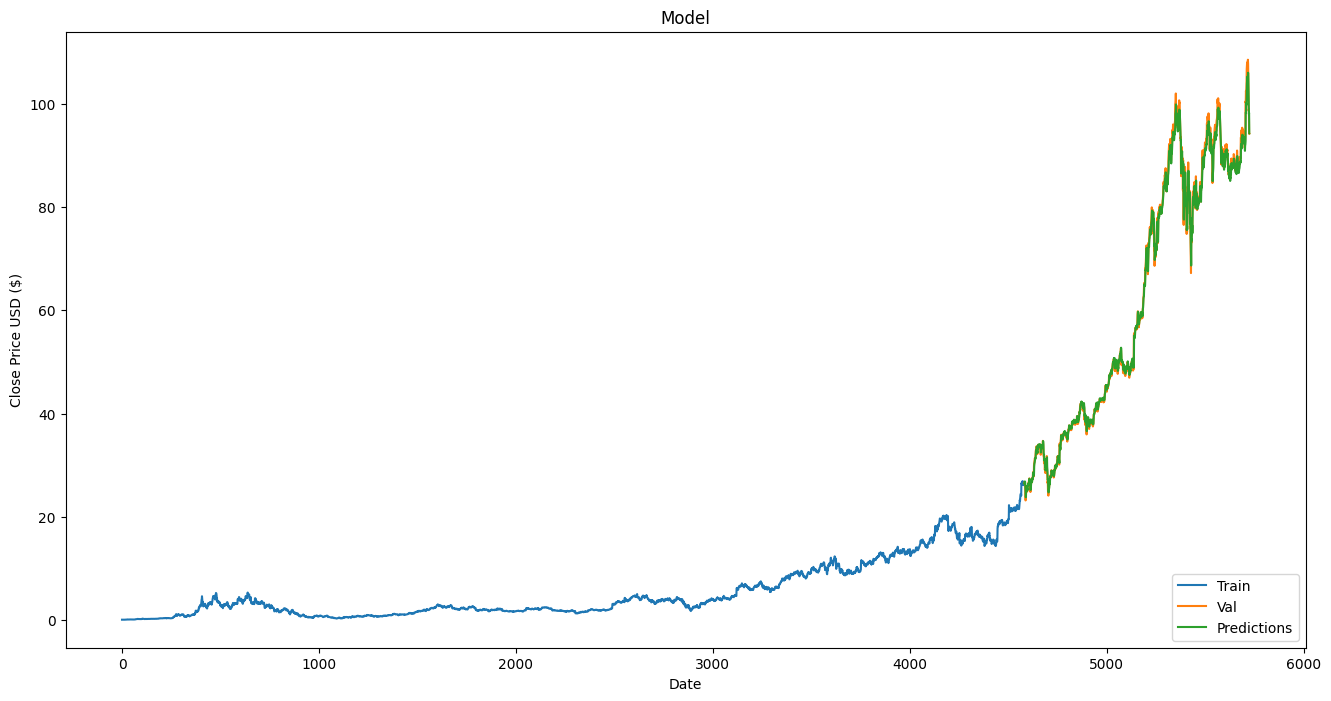

<Figure size 640x480 with 0 Axes>

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
plt.savefig('stock_preds.jpg')

In [ ]:
test.to_csv('test.csv')

0.6923076923076923


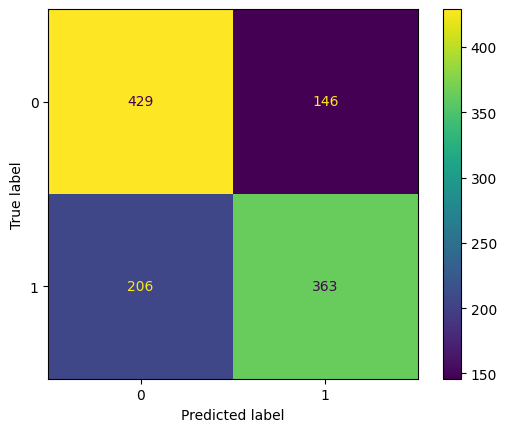

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
print(accuracy_score(test['Label'], test['Prediction']))
ConfusionMatrixDisplay.from_predictions(test['Label'], test['Prediction'])

In [ ]:
from sklearn.metrics import auc

In [ ]:
print('Hello')

Hello


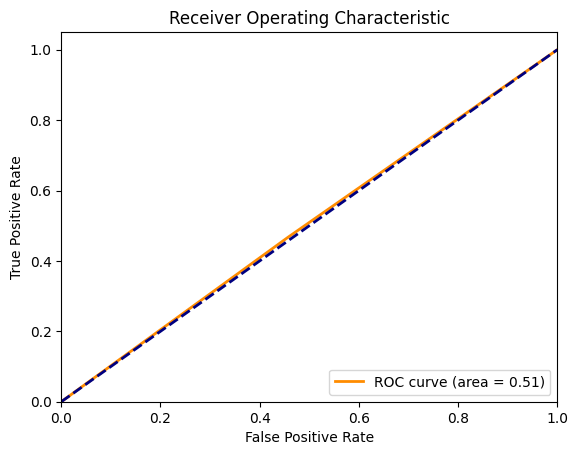

<Figure size 640x480 with 0 Axes>

In [ ]:
# y_pred_prob = dt.predict_proba(X_val)[:, 1]
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test['Label'] )

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc_auc.jpg')
